<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [279]:
%%capture
pip install pyswarms

In [280]:
%%capture
!pip install numpy==1.26

In [281]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [282]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [283]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

In [284]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [285]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [286]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [287]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [288]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [289]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [290]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [291]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [292]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [293]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [294]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [295]:
# Parâmetros do PSO
num_particles = 50
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

print("")
print("Melhores valores para λ, β, θ :", best_position)

2023-10-03 17:31:58,295 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2.15e-24
2023-10-03 17:31:58,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.1458293618416388e-24, best pos: [121.20641064   1.99660829   0.31007513]



Melhores valores para λ, β, θ : [121.20641064   1.99660829   0.31007513]


In [296]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 121.20641064197103
beta: 1.9966082909771448
theta: 0.31007513125705144


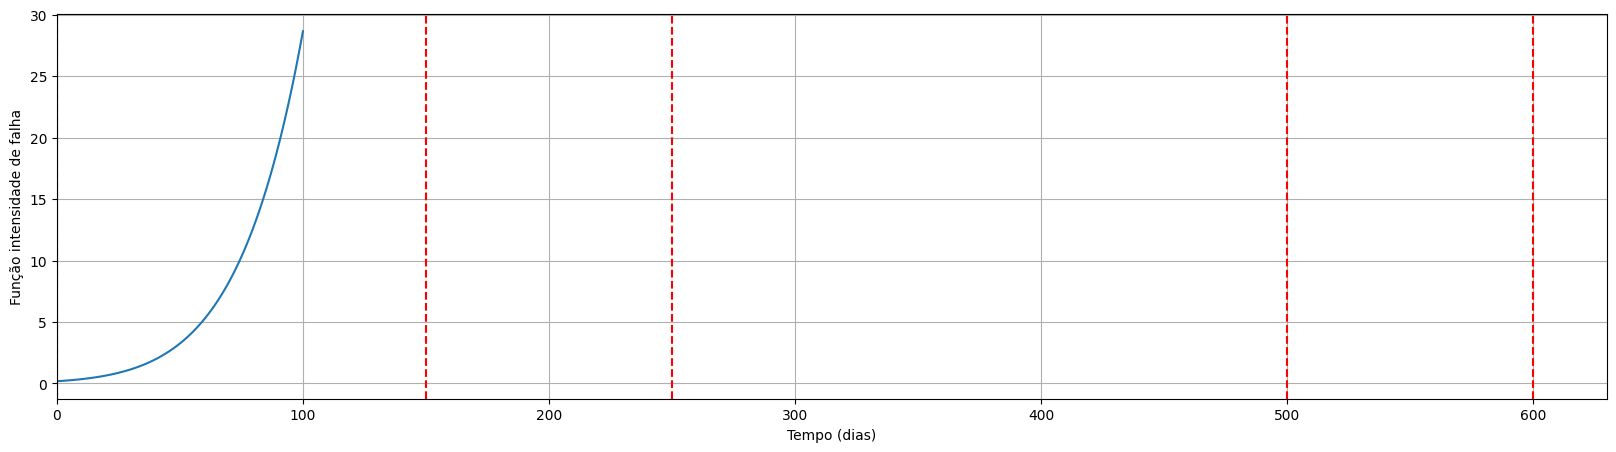

Fator ajuste:  [0.11664670649349929, 0.14361699368653869, 0.24351125087000558, 0.06013123601935755]


In [297]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [298]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [299]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-03 17:32:00,366 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=3.91e+8



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 41, 66, 289, 381, 426, 664, 691]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268]
Media de falhas:  [0, 1.9978632494594084e-05, 0.0015926758916576399, 4195.066744225647, 53142.6070421695, 151872.5075076958, 14519477.211419905, 16023143.197322588, 13131256.09167649]
Custo =  602333827.0107914


Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 58, 77, 139, 200, 254, 295, 333, 376, 434, 458, 495, 513, 564, 620, 666, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.207494

pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=3.91e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 6, 138, 166, 234, 276, 323, 479, 557, 570, 706]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268]
Media de falhas:  [0, 9.298092224724765e-14, 3.558192968694374, 9.271594567260582, 247.68140315659224, 1845.0955270464303, 9345.077854938636, 333930.4532022248, 2026970.12594499, 2559918.537576683, 9050778.087059133, 5295639.00476145]
Custo =  592547750.8625741


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 18, 108, 171, 238, 271, 404, 537, 572, 704]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755,

pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=3.91e+8<ipython-input-298-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in scalar divide
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=3.91e+8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 18, 34, 149, 165, 232, 509, 571, 631, 707]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 5.389086002057892e-09, 2.2341621574101007e-06, 5.631471756290793, 9.39413836035264, 227.46637100777141, 1178586.651084323, 3049402.54566955, 4318207.026353585, 8651309.315653864, -8326993.2990492135]
Custo =  1085076832.4339082


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 27, 33, 147, 168, 200, 237, 307, 552, 571, 633, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=3.3e+8

[0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 4.849745792078261e-06, 0.2133589984744235, 2.205858127321013, 6.335355227818241, 13.704912602148077, 310.6335719375118, 1089716.8465670987, 1782481.7282284778, 2096251.100459185, 13498520.422392523, 9805939.308513941]
Custo =  618916665.3388886


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 35, 140, 173, 187, 226, 319, 571, 633, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.0745903575640346

pyswarms.single.global_best:  70%|███████   |70/100, best_cost=3.14e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 36, 142, 168, 191, 272, 360, 503, 528, 574, 638]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465]
Media de falhas:  [0, 5.453936036415542e-06, 4.1673387729024665, 10.284532242395954, 29.08287393486908, 1853.2293307611008, 29773.35523320214, 321757.0642572207, 789576.5521955563, 1221153.7604454719, 4034690.565229277, 3191131.2220188407]
Custo =  386553230.6610153


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 2, 36, 142, 166, 183, 360, 499, 537, 574, 637, 719]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fa

pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 7, 36, 143, 163, 236, 312, 502, 537, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 4.849745792078261e-06, 3.607686948639826, 7.5176851152240145, 276.34742770170214, 6958.608068602542, 903799.562163375, 1615976.1683633632, 2346802.7800055263, 7416538.467970461, 12704687.868438438, -7725893.81741903]
Custo =  1460532591.2526836


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 9, 36, 60, 111, 144, 163, 235, 317, 558, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.2

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.14e+8
2023-10-03 17:32:01,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674914 3.20683123 3.21860184 6.48423801 3.76109054 1.44824759
 0.34207724 2.11463817 4.49427137 0.2106671  1.52431898 2.7968349
 3.70804937 4.16250969 4.26754432 2.41925788 0.01844537 4.58538593
 2.26829987 5.17577965 4.59328227 1.19795338 4.47501695 5.9431627 ]
2023-10-03 17:32:01,782 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 36, 143, 162, 234, 279, 321, 382, 485, 574, 637, 719]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 3.947698762388617e-11, 4.532224369487737e-06, 3.6076866311184035, 7.176902244497597, 253.37050032938356, 2085.817264825531, 8737.671061797699, 21103.025685324417, 538992.9816791257, 2950058.962566221, 4387079.932964676, 9743696.795409974, -11024651.14249428]
Custo =  1180731456.9149513


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 36, 143, 162, 236, 321, 574, 637, 719]
Severidade para cada subs

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17678289 3.20614843 3.2186052  6.31178255 3.75948459 1.44962297
 0.34209207 2.11372152 4.48905742 4.83925671 1.52407496 2.79686446
 3.63862852 4.16139017 4.26740427 2.41952716 3.26108043 0.26795261
 3.68672308 5.17579488 4.59379047 1.19799564 4.4750216  5.94314149]
2023-10-03 17:32:01,803 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 6, 36, 109, 142, 164, 228, 320, 503, 574, 637, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.298092224724765e-14, 4.932194801287136e-06, 0.21335908092343273, 1.653350869355771, 6.055329358574216, 186.50033614623484, 9316.06644798932, 912109.5625567669, 3044053.1037126766, 5786486.381495941, 11026784.055276444, -9403797.630581023]
Custo =  1265718248.3700647


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17679231 3.20580934 3.21861421 2.8105739  3.75993181 1.45068069
 0.34208533 2.11299835 4.4911971  6.71328724 1.5240565  2.79653298
 3.91209975 4.16208811 4.26749266 2.41922026 3.63141483 6.15958833
 3.96786882 5.17579515 4.59334743 1.19782577 4.47502202 5.94332079]
2023-10-03 17:32:01,818 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4, 36, 96, 143, 164, 229, 322, 526, 574, 637, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.05612837438267918, 1.9291497828009185, 6.202109952329115, 195.87155397423547, 9926.636898939718, 1451283.8566075556, 3110914.7709270017, 5853348.048710266, 11093645.722490769, -9336935.963366698]
Custo =  1292462401.9882116


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17679402 3.20552669 3.21862157 6.152125   3.76067433 1.45132729
 0.3420775  2.1126126  4.49328986 1.58742586 1.52409818 2.79629699
 4.13199003 4.16277476 4.26758353 2.41894632 4.52305126 4.19719336
 4.79797858 5.17579282 4.59292967 1.19768623 4.47502139 5.94345553]
2023-10-03 17:32:01,836 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 36, 143, 165, 234, 323, 375, 524, 574, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.187533245630045e-17, 5.1871655780319504e-06, 3.607687286059612, 8.267062571228465, 248.6295362274359, 10122.864135249709, 42558.790926511894, 1292765.6935776453, 2178161.5907331277, 3577360.5177501747, 8865509.918218153, -11565071.767639315]
Custo =  1148141651.947927


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17678265 3.20562152 3.21862403 1.46967901 3.76142918 1.45161907
 0.3420704  2.1124017  4.49532621 4.28463015 1.52414559 2.79613576
 4.29292349 4.16337657 4.26765428 2.41872403 6.06597261 1.73847056
 6.16645986 5.17578799 4.59259492 1.1975845  4.47502003 5.94357583]
2023-10-03 17:32:01,849 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 36, 107, 143, 165, 324, 418, 507, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.187533245630045e-17, 5.1871655780319504e-06, 0.1757055104926937, 1.7893398955375142, 10.543645867311236, 8589.358680242036, 128722.04120166527, 870644.9236588202, 1985352.7050494356, 3367281.9735016837, 8655431.373969661, -11775150.311887806]
Custo =  1145386563.4607403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.1767624  3.20596943 3.21862061 3.64786856 3.76207043 1.45183066
 0.34206475 2.11279585 4.49693837 6.9089421  1.52421193 2.79604597
 4.39091121 4.16382692 4.26769764 2.41866809 0.90215996 6.41145487
 0.82974887 5.17578178 4.59236371 1.19759455 4.47501822 5.94357004]
2023-10-03 17:32:01,866 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 3, 36, 100, 143, 165, 289, 323, 418, 547, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.187533245630045e-17, 5.1871655780319504e-06, 0.08630175426905193, 1.8664906773256869, 10.620796649099407, 2497.1424182467804, 8712.337369734914, 47681.77276105146, 1841592.179003535, 2412216.251218768, 3757109.047376052, 9092851.926384566, -11337729.759472901]
Custo =  1178965155.4412327


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674064 3.20633917 3.21861238 5.55459178 3.76252273 1.45175077
 0.34206123 2.11338659 4.49784938 1.69316541 1.52429898 2.79599754
 4.40188218 4.16400206 4.26770888 2.41875713 3.69145829 3.61210577
 3.13172857 5.17577595 4.59241442 1.19760509 4.47501652 5.94352751]
2023-10-03 17:32:01,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 36, 65, 143, 164, 319, 419, 523, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.187533245630045e-17, 5.1871655780319504e-06, 0.0008732242898126833, 2.656261035756918, 6.929221205285115, 7296.731875104642, 133190.29430706365, 1203018.3422401492, 2128776.869838051, 7070501.80077707, 12406244.679785583, -8024337.006071884]
Custo =  1396741016.6962366


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 3, 36, 70, 142, 164, 299, 316, 365, 480, 533, 543, 575, 634, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.187533245630045e-17, 5.1871655780319504e-06, 0.0019408887358385908, 2.3350916050735195, 6.737070094291965, 3625.4455213121187, 6709.058502149854, 31037.324040576168, 520711.51445632655, 764177.2979870589, 899668.1442417866, 1225580.3055591513, 2534076.1962218927, 7917158.699659247, -12513422.98619822]
Custo =  1170776914.787499



2023-10-03 17:32:01,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17672184 3.20679724 3.21860311 6.78441486 3.76254284 1.45079523
 0.34205828 2.11394074 4.49792486 4.53765012 1.52438298 2.79611459
 4.29950644 4.16386731 4.26769328 2.41888492 6.5404086  0.3989806
 5.80660226 5.17577099 4.59246529 1.19769822 4.47501508 5.94340514]
2023-10-03 17:32:01,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17670536 3.20721659 3.21859475 0.17516562 3.76237714 1.44983551
 0.34205818 2.1144815  4.4969819  1.05525941 1.52444357 2.79626568
 4.06470409 4.16341665 4.26766856 2.41903936 3.20259239 4.68033142
 0.90912425 5.17576785 4.59269398 1.19780274 4.47501388 5.94323034]
2023-10-03 17:32:0



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 36, 74, 142, 163, 298, 313, 363, 521, 549, 575, 634, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.0035250213787513854, 2.2365328970087983, 6.272260902807707, 3514.3435246400154, 6068.859430139103, 18533.376610373576, 1225345.1271217756, 1416041.5708932339, 1952227.507480082, 3260723.398142824, 8643805.901580177, -11786775.78427729]
Custo =  1179681615.0155003


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,933 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17669779 3.20750057 3.21858892 6.98605778 3.76212201 1.44879103
 0.34205841 2.11499073 4.4955257  5.58042522 1.52448182 2.79642258
 3.75312711 4.16276671 4.26761545 2.41921981 0.23275745 1.50938264
 3.86527404 5.1757682  4.59301792 1.19792923 4.47501325 5.94306077]
2023-10-03 17:32:01,934 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 35, 77, 142, 162, 311, 522, 568, 575, 634, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 3.777188628876593e-06, 0.005502148436548074, 2.165666278473268, 5.857502363810345, 5603.312284023872, 1360211.5076521118, 2821458.1298677223, 3145468.7100149705, 4453964.600677712, 9837047.104115065, -10593534.581742402]
Custo =  1375658944.0440278


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17669718 3.20764359 3.21858527 6.07896324 3.76160887 1.44784695
 0.34206422 2.115412   4.49385856 2.70738296 1.52449184 2.79667682
 3.46137217 4.16215476 4.26756144 2.4193895  5.25744314 5.60566045
 0.18438689 5.17577157 4.59338208 1.19804696 4.47501273 5.94292317]
2023-10-03 17:32:01,955 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 6, 35, 78, 113, 142, 162, 282, 309, 494, 575, 634, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.298092224724765e-14, 3.712350226805744e-06, 0.006314258629495183, 0.17885608503903874, 1.5196006568085512, 3.4831001306694276, 1939.1552879510004, 5472.473331252235, 766705.070415174, 3099902.307656839, 4408398.19831958, 9791480.701756936, -10639100.984100532]
Custo =  1169880070.847608


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17671095 3.20754175 3.21858239 4.66379085 3.76110169 1.4470594
 0.34207252 2.11558733 4.49236867 0.38306756 1.52447862 2.79691392
 3.21132469 4.16169916 4.26751015 2.41953844 2.83863547 2.2405334
 4.33109315 5.17577515 4.59370537 1.19813755 4.4750132  5.94284504]
2023-10-03 17:32:01,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 7, 35, 78, 142, 162, 309, 374, 575, 634, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 3.6485151874275983e-06, 0.006314194794455805, 2.142601396927135, 5.834437482264212, 5226.5231642752815, 40642.61174826173, 3427682.818550372, 5933353.497164406, 11316436.000601761, -9114145.685255706]
Custo =  1188502679.8855495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17672464 3.20733564 3.2185852  2.87608812 3.76064523 1.4464066
 0.34208137 2.11568592 4.49104947 5.97725047 1.52446601 2.79711342
 2.99192623 4.16141806 4.26746945 2.41964901 0.85984389 5.83622153
 1.68991899 5.17577862 4.5938936  1.19816978 4.47501453 5.94279888]
2023-10-03 17:32:01,985 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 7, 36, 78, 142, 162, 209, 309, 360, 494, 511, 564, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 4.849745792078261e-06, 0.006192199275776642, 2.142479401408456, 5.834315486745533, 72.86196446639669, 6774.220409839762, 13056.989796335496, 695748.6431736426, 822345.4906003862, 1607056.2885877728, 1855697.3739164658, 6797422.304855485, 12133165.183864, -8297416.501993468]
Custo =  1479729588.6913342


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:01,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673893 3.20710736 3.21858964 0.74101419 3.76026537 1.44630491
 0.34208933 2.11559045 4.48988027 4.89011658 1.5244451  2.79726229
 2.98465275 4.16133245 4.26745442 2.41972793 6.67526798 1.99712942
 6.38424409 5.17578196 4.59393861 1.1981802  4.47501628 5.94285469]
2023-10-03 17:32:01,997 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 7, 36, 76, 103, 142, 162, 204, 289, 310, 533, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 4.849745792078261e-06, 0.004690313645578643, 0.06704273815862548, 1.6451450209949656, 8.621693448970262, 58.74670919387275, 3385.843269651164, 6427.3450445256385, 1107833.956106368, 2641500.888110735, 7583225.819049755, 12918968.69805827, -7511612.987799197]
Custo =  1445718235.0563507


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675235 3.20686994 3.21859426 6.15847094 3.75995304 1.44674248
 0.34209621 2.11539295 4.48982554 3.74023052 1.52439797 2.79737444
 3.00559375 4.16139542 4.26746718 2.41968103 6.26584725 5.02355957
 4.21566151 5.17578474 4.59380684 1.19813883 4.47501805 5.94298554]
2023-10-03 17:32:02,012 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 7, 36, 72, 142, 162, 312, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 4.849745792078261e-06, 0.0026268790781593075, 2.28525953713385, 5.977095622470927, 5800.833158907165, 3722469.3275633296, 8792205.015528265, 14080354.415996242, -6350227.269861225]
Custo =  1339646072.922183


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 7, 36, 69, 142, 163, 235, 315, 558, 574, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 4.3323788364084784e-13, 4.849745792078261e-06, 0.0016621347382728135, 2.360417443662742, 6.396145449461651, 262.67701796891225, 7729.092991580844, 2713574.0006728168, 3398038.343697478, 8522076.168497818, 13810225.568965796, -6620356.116891671]
Custo =  1497150751.830268


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17676424 3.20664542 3.21859862 4.03879138 3.7596758  1.44751884
 0.34210044 2.11515496 4.48990541 2.94829654 1.52433867 2.79738581
 3.19737482 4.1615906  4.26748892 2.4195788  5.29313983 0.67617703
 1.93143709 5.17578572 4.59367186 1.19806692 4.47501963 5.94314337]
2023-10-03 17:32:02,032 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 36, 65, 142, 163, 182, 233, 318, 362, 488, 574, 637, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.298092224724765e-14, 4.932194801287136e-06, 0.0008729693190359384, 2.464440324594023, 6.500168330392931, 17.04486542900969, 364.6578016561888, 5229.820128070722, 26398.812463845275, 620127.7484670395, 1893571.6067854334, 3330592.5771838883, 8570890.250964392, -11859691.434893075]
Custo =  1122845679.7638907


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17677382 3.20646567 3.2186033  1.85303939 3.75965222 1.44835222
 0.34209897 2.11492421 4.49119781 2.50951333 1.52428485 2.7972515
 3.46285013 4.16196142 4.26751256 2.41943571 4.27475077 3.87335902
 6.89671767 5.17578587 4.59344548 1.19799644 4.47502066 5.94328841]
2023-10-03 17:32:02,049 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 62, 142, 164, 199, 233, 289, 319, 370, 518, 575, 637, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0005239510638004528, 2.545312210759597, 6.947290699978042, 42.72494353886485, 330.8944047530212, 1205.0868866639694, 6307.346637881412, 21396.938808269864, 1137664.8902427629, 2125946.255183828, 7325646.258970942, 12565943.932751445, -7864637.753106022]
Custo =  1388296526.42735



2023-10-03 17:32:02,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17677671 3.20634772 3.21860751 6.35005086 3.7596364  1.44909896
 0.34209694 2.11467475 4.49310868 2.75912193 1.52424528 2.79705355
 3.75005644 4.16233221 4.26754177 2.41929472 3.80072349 6.80956438
 4.8268958  5.17578454 4.5932334  1.19792061 4.47502154 5.94340926]
2023-10-03 17:32:02,067 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17677271 3.2062812  3.21860997 3.40932415 3.75993177 1.44957794
 0.3420918  2.11444421 4.49488538 3.03525657 1.52422346 2.79686838
 3.99944413 4.16270459 4.26756833 2.41916688 3.881157   2.01266346
 2.34336356 5.17578288 4.59304825 1.19785461 4.47502204 5.94348953]
2023-10-03 17:32:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 94, 142, 164, 191, 235, 320, 378, 567, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.04494242138323296, 1.8201558891774159, 6.222134378395861, 27.053711915318917, 381.39512724511735, 9261.585816423185, 46310.13620414671, 2945070.509053163, 3129354.7136694477, 8199090.401634382, 13487239.80210236, -6943341.8837551065]
Custo =  1439465997.486987


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 36, 106, 142, 164, 237, 277, 319, 386, 523, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.15922050830100257, 1.6694679420213347, 9.93618812006316, 289.6844794418708, 1901.1022458054192, 8172.591214200473, 56686.25718770085, 1248357.5171480682, 2174116.04474597, 4816028.028457228, 10104177.428925205, -10326404.256932262]
Custo =  1233439895.3886523


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17676432 3.20625287 3.21860991 0.51638942 3.76041637 1.44990797
 0.34208594 2.11424264 4.49630989 3.62726215 1.52421024 2.79670092
 4.1702045  4.1630083  4.26758983 2.41906954 3.67202905 4.0433225
 0.09747257 5.17578049 4.59290904 1.19780639 4.47502122 5.94351998]
2023-10-03 17:32:02,100 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675564 3.20631936 3.21860865 4.52560473 3.76100242 1.45006036
 0.34207907 2.11417846 4.49743402 4.37449169 1.52421268 2.7965543
 4.24812274 4.16319223 4.26759582 2.4189994  3.75244392 5.87921484
 5.17228831 5.175778



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 4, 36, 142, 164, 277, 318, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 3.3547348545496485, 7.7567133437680935, 1581.667569356742, 7588.167938456012, 2465575.3412987157, 7535311.029263651, 12823460.42973163, -7607121.256125838]
Custo =  1321862995.1430058


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 4, 36, 142, 164, 270, 318, 532, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 3.3547348545496485, 7.7567133437680935, 1196.7036458215491, 7739.120629217758, 696232.3118246534, 2256316.4216438653, 3601209.2178011495, 8936952.096809663, -11493629.589047804]
Custo =  1197951794.944522


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674714 3.20649859 3.21860708 1.15761035 3.76154891 1.45003125
 0.34207274 2.11414372 4.49768562 5.1789128  1.52424646 2.7964283
 4.1635886  4.16335346 4.26759056 2.41897681 3.822207   0.44789807
 2.81323582 5.17577615 4.59284605 1.1977799  4.47501947 5.94334792]
2023-10-03 17:32:02,134 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673969 3.20666742 3.21860501 5.01366371 3.76199062 1.44979078
 0.34206811 2.11416139 4.49780538 6.54130207 1.52428915 2.79640317
 4.04885241 4.16343239 4.26758095 2.41903698 3.80184581 2.6728616
 0.6392516  5.175774



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 4, 36, 118, 142, 164, 316, 491, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.4892296455733239, 1.6924912869071578, 9.959211464948984, 6593.1881176485, 711163.8153756389, 3090039.4568519834, 8031764.387791003, 13367507.266799517, -7063074.41905795]
Custo =  1408715539.7808442


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 4, 36, 63, 142, 163, 315, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.0006229684851790563, 2.518082197224078, 6.553810203022987, 6399.974352565525, 3707442.6715876665, 8649167.602526687, 13984910.4815352, -6445671.204322267]
Custo =  1336264472.052422


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,163 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673514 3.20684939 3.21860261 1.65616305 3.76228376 1.44927391
 0.3420645  2.11431218 4.49733093 6.97251094 1.52432775 2.79641354
 3.8835684  4.16342843 4.26756483 2.41915382 3.37841519 4.83033938
 5.90739748 5.17577428 4.5929824  1.19787574 4.47501691 5.94304724]
2023-10-03 17:32:02,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 36, 67, 114, 142, 163, 185, 314, 388, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.0012108625140151979, 0.22550285149801957, 1.5401299920040419, 5.5758579978029505, 19.13233229711189, 8541.971159890722, 61866.55184311892, 3368556.733852266, 5941794.214917362, 11277537.093925875, -9153044.591931593]
Custo =  1195138834.8749065


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673254 3.20701309 3.21860023 5.50007551 3.76246482 1.44870296
 0.34206161 2.11448699 4.49602672 6.70936312 1.52436234 2.79647179
 3.68797499 4.16315049 4.26754873 2.41927206 3.17551173 6.7287916
 3.26341363 5.17577567 4.59306464 1.19792825 4.47501563 5.94294355]
2023-10-03 17:32:02,182 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,193 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673042 3.20713834 3.21859847 2.15576004 3.76242226 1.44806596
 0.34206301 2.11468085 4.49473313 0.05773435 1.52438801 2.79653455
 3.51618568 4.1628319  4.26753298 2.41937665 3.25722693 1.07540321
 0.61443845 5.17577



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 5, 36, 71, 98, 142, 163, 181, 298, 313, 382, 483, 530, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0022605069141999226, 0.04125425255363603, 1.7294011325663239, 9.332030512393741, 18.98084224773769, 4997.168972832224, 5659.412212713234, 19143.023860588757, 512947.10579796985, 917537.4674244628, 1348492.3227105, 2693385.1188677843, 8029127.997876298, -12401453.68798117]
Custo =  1132797947.94

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 5, 36, 74, 142, 163, 203, 276, 312, 376, 492, 510, 557, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.003524936394238274, 2.236532812024285, 6.272260817823193, 52.83895021389946, 2077.911646866339, 6731.837648886303, 17774.45837514208, 640529.3632344628, 771303.9350037015, 1104238.1932569554, 1301156.4146912443, 2646049.2108485284, 7981792.089857042, -12448789.596000426]
Custo =  1163322679.97

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673168 3.20724109 3.21859754 6.29060701 3.76237612 1.4475302
 0.34206461 2.11485185 4.49351399 1.09858148 1.52440874 2.79659143
 3.36393645 4.16249189 4.26752052 2.41946963 3.64692021 2.5799173
 5.72117789 5.17577853 4.59329184 1.19801956 4.47501379 5.94293066]
2023-10-03 17:32:02,214 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673411 3.20733071 3.21859754 3.04932299 3.76195182 1.4471217
 0.34206884 2.11499106 4.49253517 2.6173923  1.52440119 2.796703
 3.32876325 4.16219064 4.26751213 2.41950355 3.63219785 4.16334022
 3.42115945 5.1757801  



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 5, 36, 75, 103, 142, 162, 201, 294, 313, 371, 504, 569, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.004070279710167354, 0.06768142044781664, 1.645783703284157, 5.337619788621234, 47.15657470768129, 4093.926715992436, 4902.876417279112, 21652.72224972576, 847434.3887783276, 1828416.429803271, 1898498.375878847, 4471735.856943943, 9807478.735952456, -10623102.949905012]
Custo =  1254689303.805509

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 75, 142, 162, 314, 367, 534, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.004070279710167354, 2.2125893970681445, 5.904425482405221, 6214.45163291999, 32945.42080026176, 1592462.3096864093, 2367745.649551998, 5009657.633263256, 10297807.033731233, -10132774.652126234]
Custo =  1238935184.503137


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,255 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17673831 3.20734924 3.21859836 6.48845689 3.76143432 1.44698292
 0.34207409 2.11508195 4.49188212 4.03115377 1.52437747 2.79684282
 3.37288847 4.16201136 4.26751232 2.41953291 4.00582094 5.70434315
 1.24718849 5.17578147 4.59346613 1.19804512 4.47501457 5.94311635]
2023-10-03 17:32:02,256 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674254 3.20733426 3.21859979 2.58314035 3.76090854 1.44721017
 0.34207902 2.11512127 4.49163867 5.37122916 1.52434451 2.79696721
 3.50931987 4.16196709 4.26751267 2.41949103 4.5623651  6.94995773
 6.58199957 5.1757



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 36, 74, 108, 142, 163, 207, 315, 365, 524, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 9.298092224724765e-14, 4.932194801287136e-06, 0.0035248526859613665, 0.11436748118038922, 1.5781051557558565, 3.7317601363092745, 62.75952601431889, 8339.944850019623, 15378.860237043926, 1293629.9895595084, 2206467.358480907, 4848379.342192166, 10136528.742660142, -10294052.943197325]
Custo =  1228390895.2057962


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 72, 90, 142, 163, 189, 316, 364, 522, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.002627045235445424, 0.016596005182654996, 1.879334548487519, 5.915062554286427, 24.351930374666672, 9036.283525826373, 32472.513809755506, 1261811.4492655855, 2200349.1932011, 4842261.176912358, 10130410.577380337, -10300171.10847713]
Custo =  1227958821.5253844


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674827 3.20718406 3.21860118 5.6635599  3.76047923 1.44759469
 0.34208334 2.11502683 4.49155571 6.99660784 1.52430941 2.79704221
 3.64956585 4.16197523 4.26752242 2.41944789 4.58214429 0.93522436
 4.99954107 5.17578244 4.59347726 1.19803158 4.47501688 5.94328508]
2023-10-03 17:32:02,287 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 69, 142, 163, 317, 364, 523, 542, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0016623008955589302, 2.3604176098200282, 6.396145615618937, 6851.618564292844, 30011.27710605186, 1284927.031412577, 1523587.581389916, 2176720.834931056, 3558650.103383304, 8846799.503851281, -11583782.182006186]
Custo =  1204273239.2230082


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.1767536  3.20704307 3.21860256 1.50414636 3.76021038 1.44795295
 0.34208678 2.11492012 4.4916526  0.93595162 1.52427838 2.79708304
 3.77722451 4.16209459 4.26753125 2.41936131 4.00060434 2.03616639
 2.7829436  5.17578192 4.59342983 1.19801685 4.47501793 5.94334865]
2023-10-03 17:32:02,303 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675758 3.20686636 3.21860372 4.84358689 3.76017998 1.44831153
 0.34208762 2.11476714 4.49186074 2.42393939 1.52426239 2.79705176
 3.87312397 4.16220618 4.26754064 2.41926146 3.4440495  3.5073166
 0.68502446 5.17578



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 282, 317, 369, 524, 540, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 1931.1811277293807, 7241.058566039747, 22133.249571248543, 1289383.5881663056, 1487540.149344414, 2172307.7477913457, 4814219.731502604, 10102369.13197058, -10328212.553886887]
Custo =  1286082320.8707237


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 63, 142, 163, 318, 374, 531, 545, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0006228835006659451, 2.518082112239565, 6.553810118038474, 7088.2710984877385, 39986.86574536613, 1486527.0632285015, 1677533.66634305, 2281763.5768194804, 7351499.264784415, 12639648.665252393, -7790933.020605074]
Custo =  1457489616.4383903


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675885 3.20669807 3.21860455 1.13180948 3.76037051 1.44861927
 0.34208643 2.11459389 4.492457   4.098803   1.52424887 2.79696244
 3.93556673 4.16232913 4.26754947 2.41917055 2.96286663 5.06371935
 5.85674415 5.17578057 4.59330055 1.19796734 4.47501909 5.94334003]
2023-10-03 17:32:02,329 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 36, 61, 142, 163, 271, 318, 380, 504, 538, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.00043956605290518844, 2.5728164400678715, 6.60854444586678, 1252.2600613123525, 7723.4541552947885, 19636.648662847565, 824584.2130081705, 1187780.8233488281, 2583557.6506765224, 5225469.63438778, 10513619.034855757, -9916962.65100171]
Custo =  1344719131.5574746


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675798 3.20658157 3.21860452 5.4479303  3.76067367 1.44882185
 0.34208401 2.11443841 4.49316982 5.54752235 1.5242369  2.79684501
 3.96928527 4.16245524 4.2675562  2.41910496 3.19814338 6.39820171
 3.24159883 5.17577962 4.59323333 1.19794074 4.47501941 5.94326504]
2023-10-03 17:32:02,344 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675549 3.2064791  3.21860383 2.51239557 3.76103247 1.44883726
 0.34208018 2.11435599 4.49404273 6.98850473 1.52423087 2.79673849
 3.96210313 4.16257456 4.26756206 2.41905417 3.752666   0.57322025
 0.79695733 5.1757



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 4, 36, 142, 164, 317, 386, 489, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 3.3547348545496485, 7.7567133437680935, 6819.346392693556, 56002.94855994831, 616254.7651489294, 1910643.5972075216, 4552555.58091878, 9840704.981386758, -10589876.704470709]
Custo =  1208754023.824574


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 4, 36, 142, 164, 316, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 3.3547348545496485, 7.7567133437680935, 6590.98561952732, 3702425.917256275, 8644150.848195296, 13979893.727203809, -6450687.958653659]
Custo =  1336408745.842457


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,372 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675178 3.20645555 3.21860295 6.89587423 3.76136758 1.44875756
 0.34207633 2.11433704 4.49488963 1.61717799 1.52424702 2.79664881
 3.9007288  4.16267897 4.26756555 2.41906369 4.90411305 2.57368932
 5.89017942 5.17577811 4.59315968 1.19790546 4.4750188  5.94307977]
2023-10-03 17:32:02,373 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674842 3.2065461  3.218602   3.78779025 3.76163953 1.44856587
 0.34207303 2.11441009 4.49549294 3.38343661 1.52426963 2.79662128
 3.80442702 4.16272976 4.26756234 2.41912558 6.47383172 4.56220297
 3.13221912 5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 36, 61, 97, 142, 163, 299, 315, 499, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.00043956605290518844, 0.04225938193407299, 1.7521900215449588, 9.354819401372376, 3647.223803801971, 6500.714688689634, 341376.6909048909, 2594310.1895551877, 3939202.985712472, 9274945.864720985, -11155635.821136482]
Custo =  1166045216.6916282


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 4, 36, 64, 142, 163, 203, 314, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.0007385234188081442, 2.4911251844623714, 6.52685319026128, 53.09354258633754, 8153.603955789011, 3714404.3833367596, 8656129.314275779, 13991872.193284292, -6438709.492573176]
Custo =  1336254501.2070804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674548 3.20667215 3.21860115 0.80377879 3.7618161  1.44833899
 0.34207011 2.11452959 4.49571623 5.60973442 1.52430051 2.79665743
 3.71735121 4.16272434 4.26755875 2.41918535 1.36686253 6.35437967
 0.56337075 5.17577767 4.59320415 1.19791107 4.47501765 5.94300597]
2023-10-03 17:32:02,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674374 3.20682826 3.2186005  5.98715377 3.76182005 1.44812494
 0.3420688  2.11465895 4.49589686 0.36270979 1.52432955 2.79673406
 3.63725738 4.16268878 4.26755241 2.41924758 3.52670152 0.58162277
 5.6338525  5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 36, 67, 103, 142, 163, 202, 313, 514, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.6235568878994416e-15, 5.100887591306023e-06, 0.0012108625140151979, 0.07461521876631881, 1.652717501602659, 5.688445507401568, 49.50835680774282, 7904.466010572717, 741265.214921393, 2718194.946919009, 4063087.7430762933, 9398830.622084808, -11031751.06377266]
Custo =  1183885337.139801


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 70, 142, 163, 196, 283, 313, 515, 564, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0019407174733387536, 2.33509143381102, 6.370819439609928, 36.34074374014237, 2775.4964636891114, 3940.5704118383856, 753119.538171594, 2182854.0641104635, 2307821.7282595127, 7249546.659198532, 12585289.538207047, -7845292.147650421]
Custo =  1456434445.245749


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674342 3.20696911 3.21860007 3.70682469 3.76165396 1.4479668
 0.34206766 2.11477114 4.49596053 2.63173016 1.52435459 2.79680607
 3.58381656 4.16264581 4.26754588 2.41930611 5.37940618 1.93201162
 3.84257373 5.17577807 4.59329932 1.19794907 4.47501636 5.94301557]
2023-10-03 17:32:02,444 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,454 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674387 3.20708369 3.2185998  1.3956701  3.76135634 1.44784898
 0.34206794 2.11485363 4.49569197 4.64974729 1.52437202 2.79687776
 3.54289488 4.162602   4.26753968 2.41935621 0.22276256 3.46495067
 1.78544745 5.17577



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 71, 142, 163, 313, 385, 481, 512, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0022605069141999226, 2.310038370542462, 6.345766376341371, 5974.960841398732, 54894.83944833217, 519460.36141109606, 733539.3026344767, 1291996.5008489448, 2636889.297006229, 7972632.176014743, -12457949.509842724]
Custo =  1124683307.4072049


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 72, 105, 142, 163, 313, 380, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.002627045235445424, 0.08621667252644499, 1.6193029022451746, 9.221932282072592, 5977.837007304463, 47773.35282346864, 3400870.211711401, 5974107.692776497, 11309850.57178501, -9120731.114072457]
Custo =  1192694522.524671


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,472 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674479 3.20714066 3.21859962 6.24008498 3.76106183 1.44775309
 0.34207022 2.11488119 4.49536972 5.89750246 1.52438254 2.7969384
 3.54504826 4.16254129 4.26753425 2.41938374 2.57742586 4.90038652
 0.01793574 5.17577901 4.59337311 1.19798299 4.47501556 5.94305006]
2023-10-03 17:32:02,474 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674635 3.20717218 3.21859996 3.60590443 3.76080372 1.44768465
 0.34207309 2.11484517 4.49486229 0.07369633 1.52437849 2.79697944
 3.54867938 4.16248445 4.26753121 2.41937207 5.17080946 6.11863287
 5.49876202 5.17577



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 72, 142, 163, 313, 375, 569, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.002627045235445424, 2.2852597032911364, 6.320987709090045, 5974.936062731481, 41489.01063559621, 3066586.8068032935, 3206569.0798781514, 8148294.010817171, 13484036.889825685, -6946544.796031782]
Custo =  1437303970.7522073


2023-10-03 17:32:02,486 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 71, 108, 142, 163, 187, 274, 314, 371, 502, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0022605069141999226, 0.11868976467324742, 1.5824274392487148, 5.618155445047623, 21.480977094411102, 2026.9047771417127, 3513.569245784878, 20088.463846984938, 810557.6863314951, 1978247.8149843886, 4551485.296049485, 9887228.175058, -10543353.510799468]
Custo =  1210784896.6402168


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674816 3.20718725 3.21860042 1.38156822 3.76061439 1.44762706
 0.34207589 2.11478775 4.49437047 1.83246224 1.52436037 2.79698988
 3.56862395 4.16244038 4.26752924 2.41934822 0.69548502 6.84936912
 4.02792959 5.17578002 4.59335943 1.19799706 4.47501563 5.94312424]
2023-10-03 17:32:02,503 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674997e+00 3.20719588e+00 3.21860116e+00 1.55701256e-01
 3.76046541e+00 1.44762155e+00 3.42078749e-01 2.11469983e+00
 4.49391836e+00 3.98262164e+00 1.52434279e+00 2.79697833e+00
 3.60440428e+00 4.16241703e+00 4.267



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 69, 142, 163, 291, 315, 370, 488, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0016623008955589302, 2.3604176098200282, 6.396145615618937, 2716.346209196093, 6605.408930745162, 22418.533341605504, 601956.4341157841, 1905502.718521818, 4478740.199586914, 9814483.078595428, -10616098.60726204]
Custo =  1202719448.9169478


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675157 3.2071373  3.21860194 5.45770338 3.7604432  1.4477549
 0.34208116 2.11462002 4.49354161 5.8213916  1.52432603 2.79696684
 3.64872066 4.16239646 4.26753038 2.4192484  6.17514026 0.84470265
 0.89429204 5.17578054 4.59329671 1.1979872  4.4750166  5.94319346]
2023-10-03 17:32:02,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 142, 163, 205, 297, 315, 370, 491, 561, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 2.411886035796847, 6.447614041595756, 58.936897958518415, 4505.978351066714, 6106.776406781053, 21919.900817641395, 642409.7501177826, 1545192.0855702003, 1855771.298010169, 6925506.985975103, 12213656.386443082, -8216925.299414385]
Custo =  1445506373.59508


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 65, 108, 142, 163, 316, 370, 493, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000873053027312846, 0.12864955230201064, 1.592387226877478, 9.195016606704895, 6625.049014753247, 35781.613660593626, 684927.1650730501, 1941892.2504661581, 4583804.234177416, 9871953.634645395, -10558628.051212072]
Custo =  1208522534.085381


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675253 3.2070816  3.21860262 3.49437663 3.76051545 1.44792266
 0.34208238 2.11455168 4.49341524 6.5317499  1.52430992 2.79695088
 3.7016352  4.16239065 4.26753514 2.41920078 0.95817048 1.75169379
 6.9025277  5.1757805  4.59326542 1.19797525 4.4750172  5.94321943]
2023-10-03 17:32:02,550 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675285 3.20701842 3.21860305 1.49896087 3.76062641 1.44809312
 0.34208217 2.11449744 4.49338793 0.72546429 1.52429803 2.79690381
 3.75070103 4.16241771 4.26754211 2.41916093 3.24788598 2.73896172
 5.67791526 5.1757



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 64, 94, 142, 163, 205, 316, 373, 505, 560, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000738438434295033, 0.02867497438365052, 1.8038884421778334, 3.957543422731251, 56.44682733965391, 8668.814681207341, 41038.14422922914, 880449.5361095214, 1634573.7847866574, 1965279.7837775522, 4607191.76748881, 9895341.167956788, -10535240.51790068]
Custo =  1294821318.8092453


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 63, 102, 142, 163, 316, 376, 543, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0006228835006659451, 0.07099259645903024, 1.6713342283976371, 9.273963608225055, 6625.127961754768, 42464.7948995467, 1874834.3910502915, 2511863.1302418658, 7581598.8182068, 12869748.218674779, -7560833.467182688]
Custo =  1409045725.3095887


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675312 3.20696013 3.21860333 6.92429426 3.76081917 1.44827576
 0.34208166 2.1144799  4.49342061 2.39280231 1.52429227 2.79685699
 3.79250094 4.1624592  4.26754892 2.41914148 5.27187809 4.10782737
 4.22891855 5.17578023 4.59322399 1.19794396 4.47501799 5.94325885]
2023-10-03 17:32:02,579 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675315 3.20688369 3.21860336 4.67923101 3.76105861 1.4484379
 0.34208018 2.11450521 4.49353521 4.04914642 1.5242896  2.79681116
 3.80794285 4.16249783 4.26755432 2.41915233 0.22670011 5.41250318
 2.52021304 5.17578



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 63, 111, 142, 163, 316, 379, 567, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0006228835006659451, 0.17813352934468119, 1.569445975016452, 3.72310095556987, 6619.577099102113, 46205.34410613868, 2939855.3993190494, 3124139.603935334, 4506068.872387582, 9794218.272855561, -10636363.413001906]
Custo =  1197538255.2730625


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 64, 142, 163, 197, 316, 382, 543, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000738438434295033, 2.4911250994778587, 6.526853105276768, 38.5192539910922, 8853.493270350007, 32644.55613503662, 1842461.7021606083, 2479490.4413521825, 5121402.425063441, 10409551.82553142, -10021029.860326048]
Custo =  1250098457.3403187


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675263 3.2068017  3.2186031  2.47286217 3.76128189 1.44854087
 0.34207881 2.11456685 4.49377363 5.76925329 1.52429065 2.79677177
 3.82025229 4.16253335 4.2675573  2.41918762 2.67411224 6.45549492
 0.93695237 5.17577976 4.59321743 1.1979274  4.47501791 5.94321324]
2023-10-03 17:32:02,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675151 3.20673369 3.21860279 0.0450007  3.76145034 1.44858655
 0.34207742 2.11463515 4.49404024 6.96691645 1.52429975 2.79673821
 3.79795805 4.16256339 4.26755678 2.41923226 4.87280576 6.8727273
 6.52732464 5.17577



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 5, 36, 65, 142, 163, 315, 384, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000873053027312846, 2.4644404083022997, 6.500168414101209, 6399.920710776603, 53209.77408251545, 3383282.438081698, 6025194.421792956, 11313343.822260935, -9117237.863596532]
Custo =  1196384655.0640087


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675048 3.20668662 3.21860243 5.09789303 3.76159545 1.44862081
 0.34207614 2.11469707 4.49428866 0.74867622 1.52431339 2.79672184
 3.76713243 4.16258178 4.26755577 2.41927981 6.75209053 0.08509656
 4.92212305 5.17577932 4.59322558 1.1979303  4.47501754 5.94313438]
2023-10-03 17:32:02,632 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 286, 315, 385, 500, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 2250.6004825215323, 6685.645516475912, 21331.738969484257, 745938.0092361168, 1934115.7143240282, 6875840.645263048, 12211583.524271563, -8218998.161585905]
Custo =  1369252043.1994128


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 142, 163, 314, 385, 496, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 2.411886035796847, 6.447614041595756, 6184.1826967928255, 54797.442791975634, 716438.2856765889, 1944459.0526321158, 4517696.533697212, 9853439.412705727, -10577142.27315174]
Custo =  1210181533.1559658


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674921 3.20666309 3.21860204 2.86108098 3.76162617 1.44865085
 0.3420751  2.11475075 4.49450769 2.08633895 1.52432709 2.79671069
 3.73502186 4.16257772 4.2675541  2.41932138 0.9006387  1.11556612
 2.79873738 5.17577915 4.5932349  1.19793423 4.47501723 5.94310095]
2023-10-03 17:32:02,651 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674805 3.20667106 3.21860166 0.45013338 3.76151879 1.44867169
 0.34207433 2.11478739 4.49463583 3.95421503 1.5243386  2.79673693
 3.70075487 4.16257138 4.26755071 2.41935786 2.55534051 2.37893266
 0.77397648 5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 68, 142, 163, 286, 314, 385, 480, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001420429961856043, 2.386015995738076, 6.421744001536984, 2250.548471026764, 6455.685128794268, 33166.40199974572, 486545.5425398925, 1860719.1894422625, 3205611.9855995467, 8541354.86460806, -11889226.821249407]
Custo =  1118496569.8760595


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674709 3.20668848 3.21860134 5.22612942 3.76129617 1.44856738
 0.34207443 2.11480096 4.4946829  6.00554623 1.52434698 2.79677825
 3.6719471  4.16255959 4.26754596 2.41938905 4.30176161 3.72133482
 6.32626939 5.17577908 4.5932598  1.19794679 4.47501664 5.94308391]
2023-10-03 17:32:02,678 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 68, 112, 142, 163, 186, 270, 314, 384, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001420429961856043, 0.18354716999990545, 1.54983604707655, 3.703491027629968, 18.381291663814853, 1738.187039764492, 7281.71811553155, 33135.613868807435, 3363208.27786799, 5936445.758933086, 11272188.637941599, -9158393.047915868]
Custo =  1193063544.9269483


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 68, 114, 142, 163, 180, 314, 383, 502, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001420429961856043, 0.2225514602542166, 1.537178600760239, 9.139807980587657, 17.942372662578478, 8654.987978550333, 33674.475167749726, 796546.0756663899, 1964236.2043192836, 6905961.135258303, 12241704.014266817, -8188877.67159065]
Custo =  1370494273.5666566


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674632 3.20672758 3.21860109 2.60869814 3.76105898 1.44840441
 0.34207488 2.11478203 4.49465116 1.19170517 1.52435349 2.79682222
 3.65271411 4.16254812 4.26754144 2.41939536 6.27106809 5.13719145
 4.44499706 5.1757792  4.59327561 1.19795375 4.47501645 5.94309144]
2023-10-03 17:32:02,697 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674627 3.20678695 3.21860101 0.44486184 3.76084731 1.44823131
 0.34207563 2.11473485 4.49458048 3.71747028 1.52435215 2.79686485
 3.63724849 4.16253191 4.26753809 2.4194002  1.592474   6.33325037
 2.25194336 5.1757



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 98, 142, 163, 180, 273, 315, 381, 509, 559, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 0.043345059797802274, 1.73149193981049, 3.885146920363908, 12.687711602354728, 1992.069066529811, 3578.1503685837783, 26790.16444056, 922319.4588777876, 1615252.7879329785, 1965832.3024028493, 4539069.783467945, 9874812.662476458, -10555769.02338101]
Custo =  1293969372.117926

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674704 3.20684255 3.21860106 6.59765765 3.76070261 1.44807767
 0.3420767  2.11467348 4.49443154 6.13402477 1.52434428 2.79690064
 3.63388566 4.16251486 4.26753572 2.41939163 4.18718209 6.99223855
 0.28246696 5.17577952 4.59330343 1.19796534 4.4750165  5.9431233 ]
2023-10-03 17:32:02,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 111, 142, 163, 276, 315, 380, 508, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 0.16870541660579796, 1.560017862277569, 9.162647242104986, 1530.8938499682165, 6869.384135421871, 29314.092421566438, 908067.7161472221, 2011862.1255738249, 3356754.921731109, 8692497.800739624, -11738083.885117844]
Custo =  1134711155.341793


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 100, 142, 163, 188, 296, 315, 379, 560, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.05478701737039059, 1.699211187572253, 3.8528661681256713, 20.967598701949505, 4561.931302202675, 6233.939479127681, 27931.658124551876, 2562449.5438962774, 2893155.542887172, 4238048.339044456, 9573791.21805297, -10856790.467804497]
Custo =  1185448075.0363579


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674794 3.20689243 3.2186012  5.11039918 3.76062411 1.44795439
 0.34207776 2.11460818 4.49427064 0.35077654 1.52433296 2.79691984
 3.64930648 4.16249812 4.26753558 2.41934567 0.14938761 6.8792326
 6.01850416 5.1757797  4.59330929 1.19796824 4.4750167  5.94314416]
2023-10-03 17:32:02,741 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 65, 115, 142, 163, 204, 273, 316, 378, 543, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000873053027312846, 0.25458365879846506, 1.5424646245625095, 9.145094004389927, 58.59944581212401, 1844.7641919568714, 3505.9957156482806, 14849.885652308632, 1839788.2465949056, 2476816.98578648, 5118728.969497738, 10406878.369965717, -10023703.31589175]
Custo =  1248629082.439015


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674902 3.20692623 3.2186014  3.21873478 3.7606125  1.44790368
 0.34207871 2.11455005 4.49412589 2.10700345 1.52431922 2.79693283
 3.66664394 4.16248332 4.26753782 2.41928426 3.496067   6.53758711
 4.00906064 5.17577985 4.59330738 1.19796927 4.47501694 5.94316449]
2023-10-03 17:32:02,758 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 65, 99, 142, 163, 288, 316, 378, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000873053027312846, 0.04978889189676901, 1.7161075590909918, 3.8697625396444097, 2424.9081813317243, 6885.952386404373, 18229.842323064724, 3382715.90589698, 6024627.889608238, 11312777.290076215, -9117804.395781253]
Custo =  1193524344.9892113


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675    3.20693976 3.2186016  1.69572988 3.76070445 1.4479113
 0.34207913 2.11451301 4.49400638 3.87137278 1.52430683 2.7969275
 3.68803636 4.16247209 4.26754093 2.41922474 6.79179838 6.22333943
 1.72320083 5.17577998 4.59330116 1.1979662  4.47501716 5.94318263]
2023-10-03 17:32:02,772 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 64, 111, 142, 163, 192, 316, 378, 563, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000738438434295033, 0.17571148510991397, 1.567023930781685, 9.169653310609103, 32.02981851770391, 8970.58912734889, 29743.746521690868, 2717870.9802799006, 2987421.597351884, 4369350.865804132, 9657500.266272109, -10773081.419585358]
Custo =  1190746826.3612828


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,786 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675075 3.20693666 3.21860178 0.04956877 3.76085465 1.44800933
 0.34207916 2.11449716 4.49396466 5.12715874 1.52429739 2.79690726
 3.71262146 4.16246656 4.26754404 2.41917195 2.81301687 5.72516268
 6.73407712 5.17578005 4.59329323 1.19796081 4.47501735 5.9431931 ]
2023-10-03 17:32:02,788 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,798 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675112 3.20690505 3.21860195 6.20018708 3.76103642 1.44813194
 0.34207863 2.11450439 4.49395537 6.32157753 1.52429476 2.79686936
 3.73467561 4.1624643  4.26754687 2.41912625 5.73881843 5.18124179
 3.63210222 5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 64, 92, 142, 163, 316, 378, 556, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000738438434295033, 0.022675873752102452, 1.8415312837312594, 3.995186264284677, 6619.849184410828, 44925.10780406902, 2396897.0827300306, 2805614.725058637, 5447526.708769895, 10735676.109237872, -9694905.576619595]
Custo =  1265307164.9602199


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 65, 96, 142, 163, 199, 288, 316, 378, 548, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000873053027312846, 0.0355775695433897, 1.7672679777635967, 9.369897357591014, 45.7345312916252, 3313.9488478417175, 7774.993052914366, 46080.25167257256, 2059874.0426559907, 2613384.6898845816, 7683120.377849516, 12971269.778317494, -7459311.907539973]
Custo =  1415610433.7045097


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,814 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675115 3.20686212 3.21860209 4.75570993 3.76120551 1.44824569
 0.34207793 2.11451131 4.49398102 0.33254964 1.52429784 2.79682653
 3.75078788 4.16246799 4.26754917 2.41909421 1.65032454 4.64619275
 0.80316252 5.17577997 4.59327482 1.1979489  4.47501753 5.94320439]
2023-10-03 17:32:02,815 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 65, 142, 163, 283, 316, 379, 509, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.000873053027312846, 2.4644404083022997, 6.500168414101209, 2006.9768950592288, 6976.133009370741, 28473.633252853328, 929095.0043875357, 2021866.015928085, 4663777.9996393435, 9951927.40010732, -10478654.285750147]
Custo =  1219737184.9943862



2023-10-03 17:32:02,827 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675109 3.20681822 3.21860216 3.19551704 3.76134994 1.44834857
 0.34207725 2.11453762 4.49401737 1.94004084 1.52430294 2.79678838
 3.75464488 4.16248162 4.26755009 2.41906727 4.67502926 4.15479638
 5.62796143 5.17577979 4.59326781 1.19794384 4.47501745 5.94320485]
2023-10-03 17:32:02,829 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,843 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675098 3.2067819  3.21860215 1.80784915 3.76147407 1.44843472
 0.34207664 2.11458278 4.49410098 3.69777415 1.52430993 2.7967575
 3.7576525  4.16250028 4.26755068 2.41906834 1.00033471 3.80909382
 2.80629873 5.17577961 4.59326581 1.19793998 4.4750173  5.94320053]
2023-10-03 17:32:0



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 283, 316, 380, 497, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 2006.9504821414325, 6976.106596452944, 19158.254216174726, 707655.1515057514, 1925852.43217044, 3307781.700622688, 8595931.101090666, -11834650.584766801]
Custo =  1128581974.9853487


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675076 3.20676069 3.21860214 0.28256247 3.76153382 1.44848154
 0.34207627 2.114635   4.49422381 5.13079274 1.52431776 2.79674459
 3.75860455 4.16251725 4.26755103 2.41910972 4.66223531 3.55864546
 0.25969833 5.17577945 4.5932666  1.19793956 4.47501713 5.94319385]
2023-10-03 17:32:02,857 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 100, 142, 163, 204, 315, 381, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.05478701737039059, 1.699211187572253, 3.8528661681256713, 53.30721797585976, 8406.231415280887, 50958.96740142403, 3398331.3335967325, 6040243.31730799, 11328392.717775967, -9102188.9680815]
Custo =  1195665945.9556355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 142, 163, 276, 315, 381, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 2.411886035796847, 6.447614041595756, 1528.178816767707, 6866.669102221362, 30078.683174197584, 3377451.049369506, 5950688.530434602, 11286431.409443116, -9144150.276414352]
Custo =  1192284060.7335756



2023-10-03 17:32:02,872 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17675054 3.20676155 3.21860206 6.02138816 3.76148174 1.44849247
 0.34207595 2.1146821  4.4943437  6.03724462 1.5243249  2.79675324
 3.75721869 4.16253145 4.26755122 2.41917812 1.10406265 3.54509087
 5.38679224 5.17577934 4.59327113 1.19794184 4.47501695 5.94317965]
2023-10-03 17:32:02,874 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.1767503  3.20676299 3.21860196 4.31194911 3.76133603 1.44846867
 0.34207592 2.11471863 4.49444263 6.99795012 1.52433008 2.79678436
 3.7478964  4.16254088 4.26755033 2.41924914 4.85032522 3.75206012
 2.99884246 5.17577929 4.59327836 1.19794586 4.47501679 5.94316461]
2023-10-03 17:32:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 142, 163, 289, 315, 382, 480, 562, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 2.411886035796847, 6.447614041595756, 2520.555710263733, 6636.510636149911, 19844.832471937334, 479260.2911535833, 1493919.0580446604, 1640004.7261128328, 2984897.522270117, 8320640.401278631, -12109941.284578837]
Custo =  1154067680.566724


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 94, 142, 163, 190, 315, 382, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 0.0275343280773082, 1.802747795871491, 5.8384758016704, 25.671182351244113, 8718.982688582773, 52655.38621886876, 3394282.5992548782, 5967520.080319975, 11303262.959328488, -9127318.72652898]
Custo =  1193418800.8008156


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,901 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674998 3.20676777 3.21860187 2.19886146 3.76118641 1.44841056
 0.34207617 2.1147307  4.49451878 1.03715775 1.52433179 2.79681749
 3.73469738 4.16254718 4.26754831 2.41931388 0.81151157 3.95344047
 0.71871798 5.17577928 4.59328547 1.19795044 4.47501666 5.94315103]
2023-10-03 17:32:02,902 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674965 3.20678773 3.21860178 0.35052604 3.76102715 1.44832394
 0.34207653 2.11471993 4.49455462 2.61690924 1.52433304 2.79684894
 3.71581585 4.16254849 4.26754573 2.41936766 3.96435485 4.29139234
 5.79032703 5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 142, 163, 185, 315, 382, 491, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 2.411886035796847, 6.447614041595756, 20.004088340904694, 8831.6051343449, 32831.73069479671, 628918.5253003277, 1904757.2806312314, 4477994.7616963275, 9813737.64070484, -10616844.045152627]
Custo =  1205593513.8474019


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,931 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674932 3.20681357 3.2186017  5.99132866 3.76088651 1.4482443
 0.34207689 2.11470923 4.49453186 4.31277952 1.52433369 2.79687594
 3.698305   4.16254198 4.26754301 2.41938512 0.46383771 4.61620194
 3.41937254 5.17577945 4.59329557 1.19795826 4.47501656 5.94313387]
2023-10-03 17:32:02,933 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 67, 117, 142, 163, 188, 315, 382, 503, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.0012107775295020866, 0.2990225360456594, 1.5312852497710319, 5.5670132555699405, 22.681745789393773, 8763.441074787333, 21971.762910574755, 804491.0301632866, 1961789.810534766, 3306682.60669205, 8642425.485700564, -11788156.200156903]
Custo =  1130598503.192623


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 315, 381, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 6399.894297858807, 48952.63028400195, 3396324.9964793106, 5969562.477544406, 11305305.356552921, -9125276.329304546]
Custo =  1193022999.3023112



2023-10-03 17:32:02,945 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674902 3.2068378  3.21860165 4.13473038 3.76079514 1.44817357
 0.34207724 2.11467855 4.49444489 5.61023481 1.5243342  2.79688989
 3.68260116 4.1625352  4.26754073 2.41937012 4.24248737 4.90420309
 1.16896306 5.17577956 4.59329936 1.19796136 4.47501656 5.94313483]
2023-10-03 17:32:02,947 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:02,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674875 3.20685924 3.21860164 2.17352016 3.7607331  1.44811567
 0.34207756 2.11463916 4.49434117 0.14266227 1.52433182 2.79689222
 3.67470861 4.1625217  4.26753897 2.41933236 1.27711958 5.10206491
 6.26809983 5.17577967 4.59329781 1.19796236 4.47501666 5.94313788]
2023-10-03 17:32:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 195, 315, 381, 507, 541, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 34.52377520650019, 8608.194608028676, 31820.208680004896, 889094.5302095731, 1271334.6760045358, 2579518.5479836916, 3924411.3441409757, 9260154.22314949, -11170427.462707978]
Custo =  1267153509.207233


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 119, 142, 163, 315, 380, 505, 544, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.3640129160174636, 1.5373863600655016, 9.14001573989292, 6402.560558102395, 47605.9632369005, 870487.4845822019, 1318187.6252928856, 1938916.270779205, 4512153.751844301, 9847896.630852815, -10582685.055004653]
Custo =  1276307245.6521907


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674853 3.20687765 3.21860165 6.97811415 3.76077398 1.44807998
 0.34207783 2.11460355 4.49422975 2.23387982 1.52432919 2.79688332
 3.66994142 4.16250813 4.26753778 2.41927624 5.55971176 5.15870593
 3.99010203 5.17577976 4.5932928  1.19796201 4.47501675 5.94314305]
2023-10-03 17:32:03,008 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674836 3.20688717 3.21860166 4.23018354 3.76085906 1.44806013
 0.34207795 2.11457359 4.49413311 4.80651619 1.52432394 2.79687208
 3.6765517  4.16249597 4.26753765 2.41922218 2.39984799 5.12408136
 1.90851329 5.1757



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 115, 142, 163, 209, 291, 315, 380, 492, 552, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.25124315581500195, 1.5391241215790463, 3.692779102132464, 69.931185958244, 3582.046860155414, 7471.109581704483, 48674.51226050259, 663043.098951135, 1363792.611421117, 1608913.9110739762, 6550638.842012996, 11886381.72102151, -8544199.964835957]
Custo =  1393806792.66652

2023-10-03 17:32:03,051 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 281, 316, 380, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 1857.9986712730076, 7013.0244041679025, 29254.63615256061, 3382351.495040493, 5955588.976105589, 11291331.855114102, -9139249.830743365]
Custo =  1192081374.342565


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674838 3.20688944 3.21860172 1.13581808 3.76098899 1.44806901
 0.34207801 2.11456542 4.49405291 0.43036396 1.52431845 2.79685951
 3.68385507 4.16248809 4.26753818 2.41918152 6.54704937 4.94524205
 0.08175806 5.17577989 4.59327916 1.19795727 4.47501698 5.94315737]
2023-10-03 17:32:03,106 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674856 3.20687748 3.21860179 5.59791836 3.76113165 1.44808626
 0.34207806 2.11456266 4.49399533 3.4704179  1.52431352 2.79684539
 3.69103998 4.16248486 4.26754016 2.41915131 2.50150475 4.7029005
 5.75633481 5.17577



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 316, 379, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 6622.327753642848, 46208.094760679414, 3405009.338535964, 5978246.81960106, 11313989.698609574, -9116591.987247894]
Custo =  1192491122.6282244


2023-10-03 17:32:03,142 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674884 3.20685552 3.21860186 2.83159263 3.76124918 1.44810338
 0.34207802 2.11457593 4.49397593 6.15942034 1.52431036 2.79683049
 3.70110661 4.16248256 4.26754221 2.41915382 5.81541771 4.46707905
 4.17014767 5.17577988 4.59326776 1.19795192 4.47501716 5.94317144]
2023-10-03 17:32:03,179 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 100, 142, 163, 316, 379, 493, 557, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.05478701737039059, 1.699211187572253, 5.7349391933711615, 6621.588937339914, 46207.355944376475, 676987.4166890448, 1473031.4587762614, 2244606.3232550593, 3626535.5917073074, 8914684.992175285, -11515896.693682183]
Custo =  1287175051.9231415


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 316, 379, 480, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 6622.327753642848, 46208.094760679414, 511428.9851480177, 1885602.6320503878, 4527514.615761646, 9815664.016229624, -10614917.669627843]
Custo =  1202734034.0093338



2023-10-03 17:32:03,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674912 3.20683486 3.21860192 0.16966655 3.76133411 1.44814517
 0.34207788 2.11460315 4.49396671 2.10101823 1.5243096  2.79681831
 3.71091534 4.16248587 4.26754468 2.41916431 0.95481863 4.28041682
 2.48484942 5.17577979 4.59326497 1.19794964 4.47501717 5.94317504]
2023-10-03 17:32:03,218 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674938 3.20681546 3.21860196 5.76991301 3.76134956 1.44820774
 0.3420777  2.11463401 4.49401516 4.89750746 1.52430934 2.79681109
 3.719271   4.16249308 4.26754682 2.41917453 3.40482396 4.20364659
 0.91966957 5.17577968 4.59326353 1.19794801 4.47501717 5.94317578]
2023-10-03 17:32:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 102, 142, 163, 288, 316, 380, 547, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.0680128822433488, 1.6683545141819556, 3.8220094947353735, 2424.8604282868155, 6885.904633359464, 47784.955585255535, 2014581.9845735016, 2585206.0567887346, 5227118.040499993, 10515267.44096797, -9915314.244889498]
Custo =  1255661168.541232


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,275 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674957 3.2068001  3.21860197 3.8912783  3.76129037 1.44827071
 0.34207743 2.11466195 4.4940962  6.8131878  1.52431136 2.79680933
 3.72452583 4.16250432 4.26754804 2.41918971 5.87064436 4.16104504
 6.73356794 5.17577959 4.59326234 1.19794657 4.47501716 5.94317602]
2023-10-03 17:32:03,276 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 194, 276, 316, 380, 562, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 32.70179327695161, 2141.3791459447402, 5100.069758984906, 27341.681507377616, 2655391.8501174795, 2945587.2144615375, 8015322.902426472, 13303472.30289445, -7127109.382963017]
Custo =  1431808134.0704992


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674965 3.20679123 3.21860197 1.57058309 3.76117816 1.44832491
 0.34207714 2.11468422 4.49417652 1.97401245 1.52431471 2.79680886
 3.72807456 4.1625158  4.26754873 2.41921628 1.13354364 4.1716609
 5.21681361 5.17577951 4.59326537 1.19794717 4.47501709 5.94317291]
2023-10-03 17:32:03,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 316, 381, 575, 636, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 6622.327753642848, 48868.181621037525, 3396240.547816346, 6038152.531527604, 11326301.931995582, -9104279.753861886]
Custo =  1195553744.998921


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 190, 285, 316, 381, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 26.306462045878618, 3045.53850573584, 7819.182007117099, 20438.78501647977, 3367811.1512117884, 5941048.632276884, 11276791.511285398, -9153790.17457207]
Custo =  1191798659.0707533


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,340 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674964 3.20679009 3.21860195 0.15688619 3.76105846 1.44835269
 0.34207689 2.11469256 4.49426297 4.11303045 1.52431784 2.79681212
 3.73123294 4.16252459 4.26754901 2.41925232 3.64858337 4.27995622
 3.54696167 5.17577947 4.59327221 1.19794954 4.475017   5.94316975]
2023-10-03 17:32:03,350 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674949 3.20680004 3.21860193 6.52186154 3.76095767 1.44835652
 0.34207675 2.11469468 4.49434219 6.25334164 1.52432076 2.79681513
 3.73274967 4.1625321  4.26754837 2.41928596 6.39474411 4.43765842
 1.7214318  5.1757



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 118, 142, 163, 188, 295, 315, 382, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.33220773212961846, 1.5354693734634524, 9.13809875329087, 26.252831287114702, 4407.700508091078, 7806.007042974936, 21014.32887876236, 3362641.541914772, 5935879.022979868, 11271621.901988382, -9158959.783869086]
Custo =  1192150290.013268


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674929 3.20681795 3.2186019  5.2411411  3.76086843 1.44833281
 0.34207662 2.11469489 4.4944015  0.99252951 1.52432331 2.79681988
 3.73023548 4.16253822 4.26754778 2.41931243 1.35912    4.58834615
 0.21028695 5.17577954 4.59328606 1.19795459 4.47501685 5.94316374]
2023-10-03 17:32:03,427 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 107, 142, 163, 200, 315, 382, 493, 544, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.11465097878864959, 1.6017943270677755, 3.7554493076211934, 42.48012537859801, 8494.559044982529, 52430.962575268524, 676681.124633868, 1222994.1207514638, 1540282.083316184, 4113519.56438128, 9449262.443389794, -10981319.242467673]
Custo =  1230463630.9583664


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 119, 142, 163, 315, 382, 548, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.3640129160174636, 1.5373863600655016, 9.14001573989292, 6402.560558102395, 50338.964088388384, 2048035.3768889655, 2601546.0241175564, 7543270.955056576, 12879013.83406509, -7551567.8517923765]
Custo =  1412088466.549344


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.1767491  3.20683798 3.21860186 3.49586717 3.76081235 1.44830125
 0.34207656 2.11467929 4.49441636 3.10737497 1.52432499 2.7968274
 3.72758357 4.16253614 4.26754625 2.41932859 3.50830919 4.72311563
 6.35286666 5.1757796  4.5932912  1.19795654 4.47501682 5.94316081]
2023-10-03 17:32:03,460 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674894 3.20685505 3.21860182 1.79123849 3.76082783 1.44825846
 0.34207663 2.11465933 4.49441199 5.48664157 1.5243262  2.7968356
 3.72361852 4.16252763 4.26754456 2.41932612 5.94207634 4.83516973
 4.86158328 5.175779



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 108, 142, 163, 201, 315, 381, 498, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.12688555537968457, 1.590623229955152, 3.74427821050857, 44.95215385764985, 8472.4178318158, 31684.43190379202, 733596.4872856222, 1941879.875286677, 6883604.806225697, 12219347.685234211, -8211234.000623256]
Custo =  1367629031.4962952


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.1767488  3.20686992 3.2186018  0.35164717 3.76086059 1.44821808
 0.34207674 2.11463556 4.49440237 0.35116584 1.52432607 2.79684289
 3.71831647 4.16251997 4.26754297 2.41931133 1.24007579 4.89482987
 3.41289584 5.17577971 4.59329304 1.1979584  4.47501683 5.94315786]
2023-10-03 17:32:03,546 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 117, 142, 163, 189, 315, 381, 505, 544, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.3029291399582591, 1.5351918536836315, 9.13782123351105, 27.57468905389129, 8744.63482294389, 21500.201736247047, 841929.0182062218, 1289629.1589169053, 1910357.8044032247, 3255250.6005605087, 8590993.479569022, -11839588.206288446]
Custo =  1192900273.9063063


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 110, 142, 163, 315, 380, 549, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.15495644430640404, 1.5708210507310763, 3.7244760312844942, 6397.145018393786, 47600.54769719189, 2093061.599484617, 2629247.5360714654, 5202485.017136561, 10538227.896145076, -9892353.789712392]
Custo =  1254865549.710662


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674868 3.20688233 3.21860177 6.43505162 3.76091929 1.44818606
 0.34207689 2.1146149  4.4943677  2.72655022 1.52432419 2.7968484
 3.71158474 4.16251015 4.26754172 2.41929683 3.93362483 4.87848819
 1.85367185 5.17577974 4.59329275 1.19795728 4.47501686 5.94315827]
2023-10-03 17:32:03,583 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 195, 315, 380, 494, 555, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 34.52377520650019, 8608.194608028676, 49811.597286826785, 692977.036653351, 1438298.0241573951, 2283898.355191505, 7225623.286130525, 12561366.165139038, -7869215.520718429]
Custo =  1522543300.7806747


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674867 3.20688139 3.21860175 4.91727424 3.76098254 1.44816808
 0.34207706 2.11460227 4.49432377 5.25115393 1.52432191 2.79685317
 3.70487591 4.16250121 4.26754076 2.4192773  6.38270438 4.85272236
 0.55578318 5.17577975 4.59329033 1.19795579 4.4750169  5.94315917]
2023-10-03 17:32:03,612 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674874 3.20686641 3.21860173 2.96024026 3.76105254 1.44816469
 0.34207722 2.11459703 4.4942747  0.03921317 1.52431955 2.79685444
 3.6989849  4.16249406 4.26754045 2.4192555  0.70689193 4.82498019
 6.74081193 5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 201, 315, 380, 507, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 47.68163114344618, 8475.147309101596, 30919.85559524616, 890698.6080349179, 2005406.3894255331, 4578643.870490629, 9914386.749499142, -10516194.936358325]
Custo =  1215590010.206933


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,667 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674881 3.20684914 3.21860175 0.560836   3.76111787 1.44817474
 0.34207737 2.11459566 4.49423019 2.36759362 1.52431727 2.79685094
 3.69513417 4.16249028 4.26754037 2.41923601 2.56841423 4.75252002
 5.44686777 5.17577971 4.59328409 1.19795189 4.475017   5.9431612 ]
2023-10-03 17:32:03,674 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 109, 142, 163, 201, 315, 380, 502, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.14028802939728904, 1.5802798178296273, 5.616007823628536, 46.823883470769815, 8474.28956142892, 20789.805185899597, 790870.4090948533, 1958560.537747747, 3303453.333905031, 8639196.212913545, -11791385.472943923]
Custo =  1129658389.1850324


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 91, 142, 163, 315, 380, 552, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.01960795677695807, 1.8603677474235307, 9.462997127250949, 6402.883539489752, 47606.28621828786, 2216268.450466047, 2699179.709338296, 4044072.5054955804, 9379815.384504095, -11050766.301353373]
Custo =  1176491912.480611


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674892 3.20683204 3.21860177 5.30682453 3.76117289 1.448189
 0.34207748 2.11460049 4.49419037 5.00879884 1.5243153  2.7968443
 3.69398845 4.16248952 4.26754054 2.41922002 4.68195045 4.66585163
 3.86456416 5.17577968 4.59328102 1.19795025 4.47501703 5.94316229]
2023-10-03 17:32:03,718 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 106, 142, 163, 195, 315, 380, 488, 563, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.10349296383550445, 1.6137403975558366, 3.7673953781092546, 31.817415088304543, 8605.48824791048, 49808.890926708584, 609830.1125527144, 1585465.5435683695, 1855016.1606403529, 4428253.641705449, 9763996.520713963, -10666585.165143505]
Custo =  1286709467.3621268


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:03,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674907 3.20681643 3.2186018  2.91819361 3.76119866 1.44820285
 0.34207755 2.11461257 4.49416377 6.7098688  1.52431372 2.79683612
 3.69585478 4.1624892  4.26754132 2.41921158 6.63662279 4.58124408
 2.02513546 5.17577965 4.59327864 1.19794955 4.47501705 5.94316335]
2023-10-03 17:32:03,786 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.14e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 199, 315, 381, 493, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 42.83838943033909, 8519.424319411477, 31731.438391387695, 658182.8259407516, 1915147.91133386, 3260040.707491144, 8595783.586499657, -11834798.09935781]
Custo =  1124760231.1013272


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:04,012 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674922 3.20680333 3.21860183 1.08856549 3.76119337 1.44821556
 0.34207761 2.11462544 4.49416581 1.36804355 1.52431386 2.79682864
 3.70027831 4.16249124 4.26754242 2.41921288 1.0964871  4.50533169
 0.4144024  5.17577962 4.59327755 1.19794994 4.47501704 5.94316431]
2023-10-03 17:32:04,017 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:04,307 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674934 3.20679759 3.21860185 6.37549594 3.76117937 1.44822823
 0.34207762 2.11463885 4.49418991 3.38789311 1.52431474 2.79682353
 3.70632307 4.16249504 4.26754394 2.41921933 2.96621367 4.44347909
 6.06999083 5.1757



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 142, 163, 190, 294, 315, 381, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 2.4380274905059944, 6.4737554963049035, 26.306462045878618, 4226.519553923922, 5157.85444463477, 47710.59043077791, 3395082.9566260865, 5968320.437691182, 11304063.316699695, -9126518.369157773]
Custo =  1193197179.1068838


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:04,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.17674945 3.20679308 3.21860187 4.14731365 3.76114929 1.44824256
 0.34207761 2.1146508  4.49422449 5.63297131 1.52431563 2.79682056
 3.71184059 4.16250018 4.26754541 2.41922692 5.18638316 4.40876052
 4.04941562 5.1757796  4.59327797 1.19795171 4.47501701 5.94316529]
2023-10-03 17:32:04,449 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 103, 142, 163, 279, 315, 381, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.20749490833922268, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.07565734427211208, 1.6537596271084523, 3.8074146076618702, 1716.4150596547856, 6807.351691877067, 30019.36576385329, 3377391.731959162, 5950629.213024258, 11286372.092032772, -9144209.593824696]
Custo =  1192307435.7992814


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 36, 66, 98, 142, 163, 182, 276, 315, 381, 575, 635, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06013123601935755, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.14361699368653869, 0.07459035756403465, 0.07459035756403465, 0.20749490833922268, 0.07459035756403465, 0.14361699368653869, 0.20749490833922268, 0.07459035756403465, 0.20749490833922268]
Media de falhas:  [0, 1.506344089548196e-14, 5.015903078194724e-06, 0.001029471467596512, 0.04394144284979955, 1.7320883228624873, 5.767816328661396, 16.312513427278155, 2223.7051741128826, 7562.1954595665375, 20317.762372869693, 3367690.128568178, 5940927.609633274, 11276670.488641787, -9153911.19721568]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.14e+8
2023-10-03 17:32:04,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314309220.5012563, best pos: [3.1767495  3.20679398 3.21860188 1.89797179 3.76111057 1.44825595
 0.34207754 2.11465847 4.49425957 6.83317782 1.52431721 2.79681808
 3.71670809 4.16250517 4.26754669 2.41924033 0.66721606 4.41269871
 2.14030477 5.17577961 4.59327865 1.19795322 4.47501698 5.94316526]


Custo =  1191693016.255814


In [300]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(pbest_cost[0])

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), pbest_cost[0], lamb, beta, theta, num_particles, max_iterations, dimensions, options]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)


In [301]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 121.20641064197103
beta: 9.983041454885724
theta: 0.31007513125705144


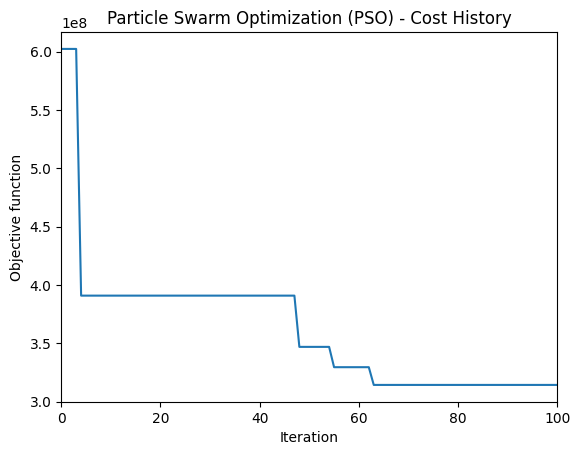

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 1191693016.255814


In [302]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

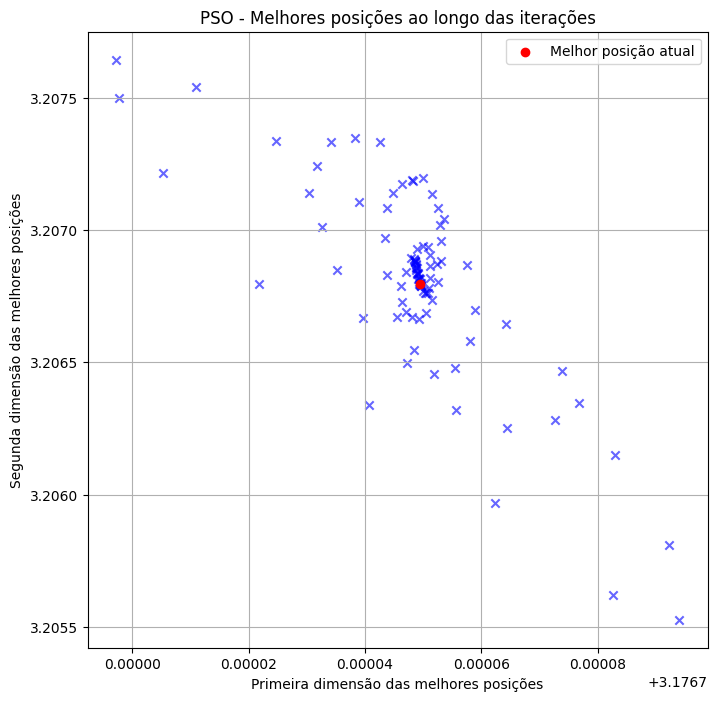

In [303]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()